How to start SOLR in cloud mode: solr start -e cloud -noprompt   
How to stop SOLR: solr stop -p 8983 or solr stop -all 

Note: Need to be in solr bin directory. Will have a script later.

In [ ]:
#!pip3 install pysolr

In [1]:
import pysolr
import requests
import pandas as pd
import timeit
import gc 
import json

In [2]:
# release memory
gc.collect()

0

### Read data, take a subset of 1 mi rorecords, and create a json to be consumed by json collection

In [3]:
complaints = pd.read_csv("./tc/complaints.csv")

C:\Users\Isha Nagar\AppData\Local\Temp\ipykernel_9968\373673723.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  complaints = pd.read_csv("./tc/complaints.csv")


In [26]:
complaints_sub = complaints.iloc[0:1000000]

In [4]:
complaints_sub_2 = complaints.iloc[1000001:2000000]

In [22]:
complaints_small = complaints.iloc[0:1]

In [23]:
complaints_small

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-07-19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",OH,44484.0,Servicemember,NaN,Web,2022-07-19,In progress,Yes,NaN,5784967


In [24]:
s = timeit.default_timer()
complaints_small.to_json("complaints_small.json", orient='records', lines=True)
e = timeit.default_timer()
e - s

0.0017248000001472974

creating json from dataframe for 3 million records & writing json to a file on disk took: "resulted in memory error hence need to batch"

creating json from dataframe for 1 million records & writing json to a file on disk took: 102.56 sec

### Create collection programatically

In [6]:
AIPS_SOLR_HOST = "aips-solr"
AIPS_NOTEBOOK_HOST="aips-notebook"
AIPS_ZK_HOST="aips-zk"
AIPS_SOLR_HOST = "localhost"
AIPS_NOTEBOOK_HOST="localhost"
AIPS_ZK_HOST="localhost"
AIPS_SOLR_PORT = "8983"
AIPS_NOTEBOOK_PORT="8888"
AIPS_ZK_PORT="2181"

solr_url = f'http://{AIPS_SOLR_HOST}:{AIPS_SOLR_PORT}/solr/'
solr_collections_api = f'{solr_url}admin/collections'


### Create complaints collection

In [7]:
def create_collection(collection_name):
    #Wipe previous collection
  wipe_collection_params = [
      ('action', "delete"),
      ('name', collection_name)
  ]

  print(f"Wiping '{collection_name}' collection")
  response = requests.post(solr_collections_api, data=wipe_collection_params).json()

  #Create collection
  create_collection_params = [
      ('action', "CREATE"),
      ('name', collection_name),
      ('numShards', 1),
      ('replicationFactor', 1) ]

  print(create_collection_params)

  print(f"Creating '{collection_name}' collection")
  response = requests.post(solr_collections_api, data=create_collection_params).json()
  print(response)

In [8]:
create_collection("complaints")

Wiping 'complaints' collection
[('action', 'CREATE'), ('name', 'complaints'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'complaints' collection


NameError: name 'print_status' is not defined

In [13]:
collection = 'complaints'

### Add documents to complaints collection

In [25]:
complaints_json = []
for line in open('complaints_small.json', 'r'):
    complaints_json.append(json.loads(line))

In [26]:
complaints_json

[{'Date received': '2022-07-19',
  'Product': 'Credit reporting, credit repair services, or other personal consumer reports',
  'Sub-product': 'Credit reporting',
  'Issue': 'Improper use of your report',
  'Sub-issue': 'Reporting company used your report improperly',
  'Consumer complaint narrative': None,
  'Company public response': None,
  'Company': 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
  'State': 'OH',
  'ZIP code': 44484.0,
  'Tags': 'Servicemember',
  'Consumer consent provided?': None,
  'Submitted via': 'Web',
  'Date sent to company': '2022-07-19',
  'Company response to consumer': 'In progress',
  'Timely response?': 'Yes',
  'Consumer disputed?': None,
  'Complaint ID': 5784967}]

In [ ]:
# # This is just an example document. Actual document will be different

# complaints_json = [
#     {
#         "id": "doc1",
#         "title": "Worst",
#         "description": "The interesting thing is that the person in the wrong made the right decision in the end."
#     },
#     {
#         "id": "doc2",
#         "title": "Best",
#         "description": "My favorite book is the cat in the hat, which is about a crazy cat who breaks into a house and creates a crazy afternoon for two kids."
        
#     },
#     {
#         "id": "doc3",
#         "title": "Okay",
#         "description": "My neighbors let the stray cat stay in their garage, which resulted in my favorite hat that I let them borrow being ruined."        
#     }
# ]

In [27]:
print(f"\nAdding Documents to '{collection}' collection")
response = requests.post(f"{solr_url}{collection}/update?commit=true", json=complaints_json).json()
print("Status: " "Success" if response["responseHeader"]["status"] == 0 else "Failure" )


Adding Documents to 'complaints' collection
Status: Success


### Query the complaints collection

Different ways to form the query

In [62]:
query = "Real estate commission excessive"
#another way to express the above query
#query = '{!func}query("fake") {!func}query("fraud") {!func}query("scam")'

Both of the above representations of the query are same.  
What other functions can we use in the query?  

Note: The default ranking function is BM25 which is a variant of TF IDF accounting for term frequency saturation & increases impact of document normalization  

Here is a partial list of common relevance techniques:
- **Geospatial Boosting**: Documents near the user running the query should rank higher.  
- **Date Boosting**: Newer documents should get a higher relevancy boost  
- **Popularity Boosting**: Documents which are more popular should get a higher relevancy
boost.  
- **Field Boosting**: Terms matching in certain fields should get a higher weight than in other
fields  
- **Category Boosting**: Documents in categories related to query terms should get a higher
relevancy boost.  
- **Phrase Boosting**: Documents matching multi-term phrases in the query should rank
higher than those only matching the words separately.  
- **Semantic Expansion**: Documents containing other words or concepts that are highly
related to the query keywords and context should be boosted.  

The above are also termed as **relevancy boosting** techniques.

Review: Additive and Multiplicative boosting techniques to boost the relevance score based on features

In [64]:
request = {
    "query": query,
    "fields": ["Date_received", "Company", "Consumer_complaint_narrative"],      #, "score", "[explain style=html]"],
    "params": {
      "qf": "Consumer_complaint_narrative",              # specifies which fields in the document to search on 
      "defType": "edismax",                              # edismax is a query parser
      "indent": "true"
    }
}
from IPython.core.display import display,HTML
display(HTML(f"<br/><strong>Query: </strong><i>{query}</i><br/><br/><strong>Ranked Docs:</strong>"))
response = str(requests.post(f"{solr_url}{collection}/select?", json=request)\
               .json()["response"]["docs"]).replace('\\n', '').replace(", '", ",<br/>'")
display(HTML(response))
#print(str(response))
#q2 = 'http://localhost:8983/solr/complaints/select?q=*&wt=json'

C:\Users\Isha Nagar\AppData\Local\Temp\ipykernel_9968\1087735250.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML


## Scratch

### Connecting to solr.  
First url fails, Second succeeds

In [ ]:
solr = pysolr.Solr('http://localhost:8983/solr/', timeout=10)   #fails healthcheck as no collection is specified
solr = pysolr.Solr('http://localhost:8983/solr/gettingstarted', timeout=10)

### Health check looks ok. Meaning connection has been made.

In [ ]:
#health check
solr.ping()

### ADD method is not working

In [ ]:
# How you'd index data.
solr.add([
    {
        "id": "doc_1",
        "title": "A test document",
    },
    {
        "id": "doc_2",
        "title": "The Banana: Tasty or Dangerous?",
        "_doc": [
            { "id": "child_doc_1", "title": "peel" },
            { "id": "child_doc_2", "title": "seed" },
        ]
    },
])


In [ ]:
# You can index a parent/child document relationship by
# associating a list of child documents with the special key '_doc'. This
# is helpful for queries that join together conditions on children and parent
# documents.

# Later, searching is easy. In the simple case, just a plain Lucene-style
# query is fine.
results = solr.search('bananas')



In [ ]:
# The ``Results`` object stores total results found, by default the top
# ten most relevant results and any additional data like
# facets/highlighting/spelling/etc.
print("Saw {0} result(s).".format(len(results)))

##  Python with JSON 
https://solr.apache.org/guide/7_1/using-python.html

#### Search for documents in gettingstarted collections

In [ ]:
!pip3 install urllib

In [ ]:
from urllib.request import *
import json
#q1 returns no results, q2 returns 2 results correctly
q1 = 'http://localhost:8983/solr/gettingstarted/select?q="Enterprise"&wt=json'
q2 = 'http://localhost:8983/solr/complaints/select?q=*&wt=json'
connection = urlopen(q2)    
response = json.load(connection)
print(response['response']['numFound'], "documents found.")

In [ ]:
# Print the name of each document.

for document in response['response']:
    print(response)
    print("  ID =", document['id'], "Title = ",document['title'], "Description = ", document['description'])

In [ ]:
def retrieveDocuments():
    
    
#    q2 = 'http://localhost:8983/solr/complaints/select?q=*&wt=json'
    q2 = 'http://localhost:8983/solr/complaints/select?q=*&wt=json'
  
    connection = urlopen(q2)    
    response = json.load(connection)
    list = response['response']['docs']
#    print(response['response']['doc']['id'])
    print(response['response']['numFound'], "documents found.")
    return list

In [ ]:
list = retrieveDocuments()

In [ ]:
[print(l['Consumer complaint narrative']) for l in list]

In [ ]:
list

import numpy as np

In [60]:
(10000* (np.log(100010/100000)))/100010 + (10* (np.log(100010) - np.log(10)))/100010

0.0009309504416868127

9.998500183311402e-06

### Query example  
The query below does a few interesting things:  
- It constructs a query vector containing four features: BM25 Keywords relevance score
(higher is better), geo distance (lower is better), publication date (newer is better), and
popularity (higher is better).  
- Each of the feature values is scaled between and so that they are all comparable, 0 25
with the best keyword/geo/publication date/popularity score getting a score of , and the 25
worst getting a score close to . 0  
- Thus a "perfect score" would add up to (25 + 25 + 25 + 25), and the worst score 100
would be approximately . 0  
- Since the relative contribution of is specified as part of the query for each function, we 25
can easily change the weights of any feature on the fly to give preference to certain
features in the final relevance calculation.

q =  
 {!func}scale(query(**keywords**),0,25)   
 {!func}recip(**geodist**($lat_long_field,$user_latitude,$user_longitude),
 1,25,1)  
 {!func}recip(ms(NOW/HOUR,**modify_date**),3.16e-11,25,1)  
 {!func}scale(**popularity**,0,25)  
 &keywords="basketball"&  
 lat_long_field=location&  
 user_latitude=33.748&  
 user_longitude=-84.391

# Learning to rank for generalizable search relevance

Generalizable search learns the underlying patterns that drive relevance.  
Instead of memorizing that the article entitled "Zits: bumps on nose" is the answer for the query weird bump on nose - cancer?, we observe the underlying pattern - that a strong title match corresponds to high probability of relevance. If we can learn these patterns, encoding them into a model, then we can give relevant results even for search queries we’ve never seen.

Manual relevance - observe factors that correspond with relevant results and we combine those factors mathematically into a ranking function. The ranking function returns a relevance score that orders results as closely as possible to our ideal ranking.

One approach to coming up with a generalizable ranking function is Learning to Rank (LTR):  LTR takes our proposed relevance factors, and learns an optimal ranking function. Learning to Rank takes several forms: from a simple set of linear weights to a complex deep learning model.

We will Solr LTR plugin function.  We note that Elasticsearch also has a community provided plugin (https://github.com/o19s/elasticsearch-learning-to-rank).

In following image, we start with a labeled dataset, do some sort of feature logging, then we get the actual feature values so we have (example) [-.45, 1.99, 0.33] with a label +1.  We train model on this training set, and use the model for inferece       

The labeled dataset is called judgement list which is simply labeling a (returned) document as relevant or not.
Features are simply the query elements - title: (${keywords})
Inference will assign values to query elements for each doc and arrive at a relevance score to hanl rank the documents.

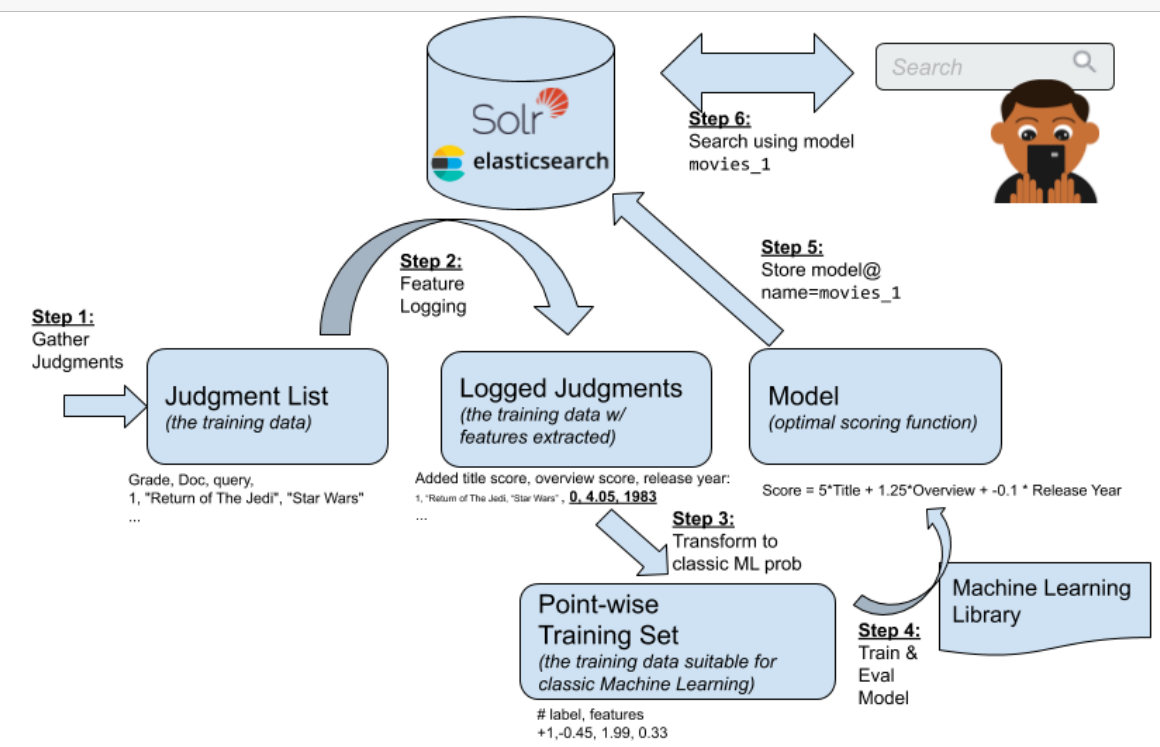

Steps to train an LTR model, as outlined in greater depth below:  

- Gather judgments: we derive judgments from clicks or other sources. We’ll cover this
step in depth in Chapter 11.  
- Feature logging: to train a model, we must combine the judgments with features to see
the overall pattern. This step requires us to ask the search engine to store and compute
queries representing the features.  
- Transform to traditional machine learning problem: you’ll see that most LTR really is
about translating the ranking task into something that looks more like the "Traditional
Machine Learning" column in Table 10.1.  
- Train and evaluate model: here we construct our model and confirm it is, indeed,
generalizable, and thus will perform well for queries it hasn’t even seen yet.  
- Store the model: we upload the model to our search infrastructure, tell the search engine
which features to use as input, and enable it for users to use in their searches.  
- Search using the model: we finally can execute searches using the model!


### 1. Gather judgements

Example judgements list - 2 issues arise which we mention below.

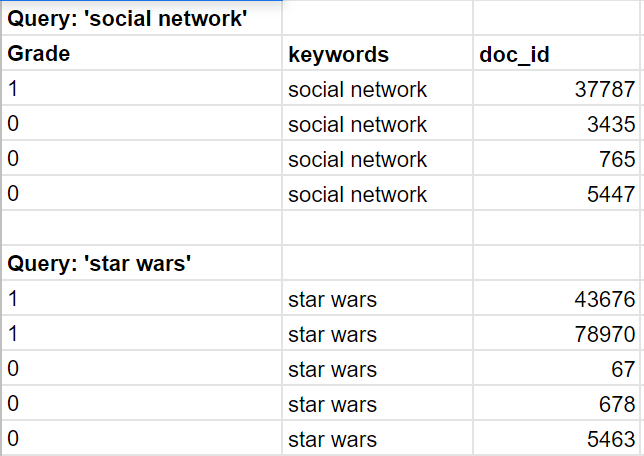

1. How do we generalize from the 2 specific queries selected below?
2. Verify if the features are the keywords

Programatically, 

In [65]:
from ltr.judgments import Judgment
Judgment(grade=1, keywords='social network', doc_id=37799)

ModuleNotFoundError: No module named 'ltr'

## References

1. https://kmwllc.com/index.php/2020/03/20/understanding-tf-idf-and-bm-25/
2. https://opensource.com/article/17/11/learning-rank-apache-solr (Ranking in Solr with machine learning)  
3. https://github.com/airalcorn2/Solr-LTR/blob/master/fall-lecture-16-learning-to-rank.pdf